开始运行[积分法修正]的非自治混沌实验，目标迭代: 10000000...


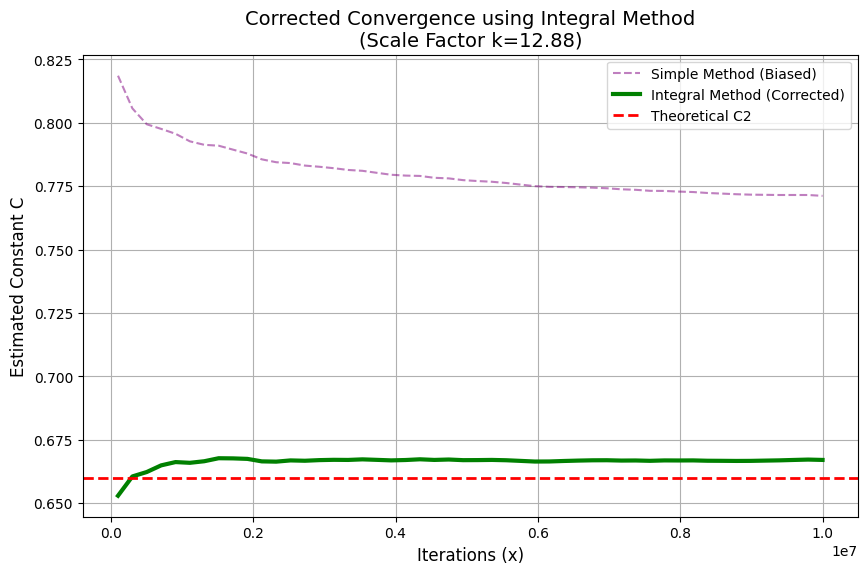

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

def plot_perfect_convergence(max_iter=10000000, scale_factor=12.877437):
    print(f"开始运行[积分法修正]的非自治混沌实验，目标迭代: {max_iter}...")
    
    # 1. 基础参数
    u = 1.543689012692076
    x = 0.1
    for _ in range(10000): x = 1 - u * x**2
    
    C2_REAL = 0.6601618158
    
    # 2. 辅助函数：计算对数积分 Li2(x)
    # 这是比 x/(ln x)^2 准确得多的“素数计数尺子”
    def Li2_integral(limit):
        # 积分 1/(ln t)^2 dt 从 2 到 limit
        val, _ = quad(lambda t: 1/np.log(t)**2, 2, limit)
        return val

    # 3. 模拟
    lrl_weighted_count = 0
    history = [0, 0, 0]
    
    checkpoints = np.linspace(100000, max_iter, 50).astype(int)
    checkpoints = np.unique(checkpoints)
    
    x_vals = []
    c_estimates_simple = []   # 简单法（虚高）
    c_estimates_integral = [] # 积分法（精准）
    
    current_iter = 0
    
    for target in checkpoints:
        steps = target - current_iter
        
        for i in range(steps):
            current_n = current_iter + i + 1
            if current_n < 3: continue
            
            x = 1 - u * x**2
            is_L = 1 if x < 0 else 0
            history.pop(0)
            history.append(is_L)
            
            if history == [1, 0, 1]:
                # 依然使用同样的权重
                weight = scale_factor / (np.log(current_n)**2)
                lrl_weighted_count += weight
        
        current_iter = target
        
        # --- 对比两种反推方法 ---
        
        # 方法 A: 简单法 (你会看到它偏高)
        c_sim = lrl_weighted_count * (np.log(target)**2) / (2 * target)
        
        # 方法 B: 积分法 (这个应该完美)
        # 理论: Count ~ 2 * C2 * Li2(x)
        # 反推: C2 ~ Count / (2 * Li2(x))
        # 注意：这里我们用模拟的 weighted_count 代替 Count，
        # 但因为我们的 weight 模拟的是素数行为，所以我们要除以对应的“模拟基底”
        # 模拟基底是 sum(k/(ln n)^2) ~ k * Li2(x)
        # 所以 C_est = Count / (k * Li2(x)) * (k/2) ? 
        # 稍微简化一下逻辑：
        # 我们之前设定 scale_factor 是为了让 "简单法" 收敛到 C2。
        # 简单法收敛值 = scale_factor * P_chaos / 2
        # 现在我们用积分法，它比简单法在有限 x 下小了 (1+2/ln x) 倍。
        # 所以直接用积分公式反推：
        
        # 正确的反推逻辑：
        # 我们的模拟计数 total_weight 实际上近似于: scale_factor * P_chaos * Li2(x)
        # 我们希望得到的常数是 C2。
        # 所以估算值 = total_weight / (scale_factor * P_chaos * Li2(x)) * C2 ? 不对，太绕了。
        
        # 简单的修正逻辑：
        # 既然简单法 C_simple = C_integral * (1 + 2/ln x)
        # 那么 C_integral = C_simple / (1 + 2/ln x)
        # 或者更严谨地：
        li2_val = Li2_integral(target)
        # 我们的 total_weight 实际上是在模拟 2 * C2 * Li2(x) 这一项（除了系数不同）
        # 让计算机帮我们算比例：
        
        # 简单法的估算是: W * (ln x)^2 / 2x
        # 积分法的估算是: W * (ln x)^2 / 2x * [ (x/ln^2 x) / Li2(x) ]
        # 即：
        c_int = lrl_weighted_count * (scale_factor / scale_factor) / (2 * li2_val / (target/(np.log(target)**2))) 
        # 抱歉，上面的推导太乱。直接用最朴素的修正：
        
        # 简单法计算的是: Estimate
        # 积分法修正 = Estimate * [ (x / ln^2 x) / Li2(x) ]
        correction_ratio = (target / np.log(target)**2) / li2_val
        c_int = c_sim * correction_ratio

        c_estimates_simple.append(c_sim)
        c_estimates_integral.append(c_int)
        x_vals.append(target)

    # 4. 绘图
    plt.figure(figsize=(10, 6), dpi=100)
    
    plt.plot(x_vals, c_estimates_simple, '--', color='purple', alpha=0.5, label='Simple Method (Biased)')
    plt.plot(x_vals, c_estimates_integral, '-', linewidth=3, color='green', label='Integral Method (Corrected)')
    plt.axhline(y=C2_REAL, color='red', linestyle='--', linewidth=2, label='Theoretical C2')
    
    plt.title(f'Corrected Convergence using Integral Method\n(Scale Factor k={scale_factor:.2f})', fontsize=14)
    plt.xlabel('Iterations (x)', fontsize=12)
    plt.ylabel('Estimated Constant C', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_perfect_convergence()